#### Lesson: Shortest Paths

In [8]:
import numpy as np

In [9]:
from numpy import inf

Q = np.array([[inf, 1,   5,   3,   inf, inf, inf],
              [inf, inf, inf, 9,   6,   inf, inf],
              [inf, inf, inf, inf, inf, 2,   inf],
              [inf, inf, inf, inf, inf, 4,   8],
              [inf, inf, inf, inf, inf, inf, 4],
              [inf, inf, inf, inf, inf, inf, 1],
              [inf, inf, inf, inf, inf, inf, 0]])

In [10]:
num_nodes = 7
J = np.zeros(num_nodes, dtype=np.int)       # Initial guess
next_J = np.empty(num_nodes, dtype=np.int)  # Stores updated guess
max_iter = 500
i = 0

while i < max_iter:
   for v in range(num_nodes):
      next_J[v] = np.min(Q[v, :] + J)
   if np.equal(next_J, J).all():
      break
   else:
      J[:] = next_J   # Copy contents of next_J to J
      i += 1

print("The cost-to-go function is", J)

The cost-to-go function is [ 8 10  3  5  4  1  0]


Ecercise 1

![Ex1](img/sp_1.png)

In [11]:
num_nodes = 100
destination_node = 99

def map_graph_to_distance_matrix(in_file):

   # First let's set of the distance matrix Q with inf everywhere
   Q = np.ones((num_nodes, num_nodes))
   Q = Q * np.inf

   # Now we read in the data and modify Q
   infile = open(in_file)
   for line in infile:
      elements = line.split(',')
      node = elements.pop(0)
      node = int(node[4:])    # convert node description to integer
      if node != destination_node:
          for element in elements:
              destination, cost = element.split()
              destination = int(destination[4:])
              Q[node, destination] = float(cost)
   Q[destination_node, destination_node] = 0

   infile.close()
   return Q

In [12]:
def bellman(J, Q):
   num_nodes = Q.shape[0]
   next_J = np.empty_like(J)
   for v in range(num_nodes):
      next_J[v] = np.min(Q[v, :] + J)
   return next_J


def compute_cost_to_go(Q):
   J = np.zeros(num_nodes)      # Initial guess
   next_J = np.empty(num_nodes)  # Stores updated guess
   max_iter = 500
   i = 0

   while i < max_iter:
      next_J = bellman(J, Q)
      if np.allclose(next_J, J):
         break
      else:
         J[:] = next_J   # Copy contents of next_J to J
         i += 1

   return(J)

In [13]:
def print_best_path(J, Q):
    sum_costs = 0
    current_node = 0
    while current_node != destination_node:
        print(current_node)
        # Move to the next node and increment costs
        next_node = np.argmin(Q[current_node, :] + J)
        sum_costs += Q[current_node, next_node]
        current_node = next_node

    print(destination_node)
    print('Cost: ', sum_costs)

In [14]:
Q = map_graph_to_distance_matrix('graph.txt')
J = compute_cost_to_go(Q)
print_best_path(J, Q)

0
8
11
18
23
33
41
53
56
57
60
67
70
73
76
85
87
88
93
94
96
97
98
99
Cost:  160.55000000000007


#### Lesson: Job Search I: The McCall Search Model

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

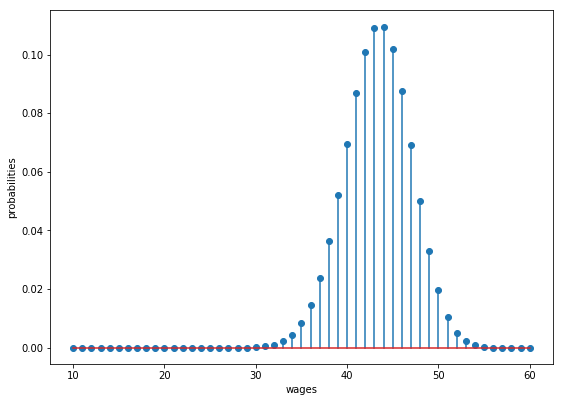

In [2]:
n, a, b = 50, 200, 100
w_min, w_max = 10, 60
w_vals = np.linspace(w_min, w_max, n+1)
dist = BetaBinomial(n, a, b)
ϕ_vals = dist.pdf()

fig, ax = plt.subplots(figsize=(9, 6.5))
ax.stem(w_vals, ϕ_vals, label='$\phi (w\')$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

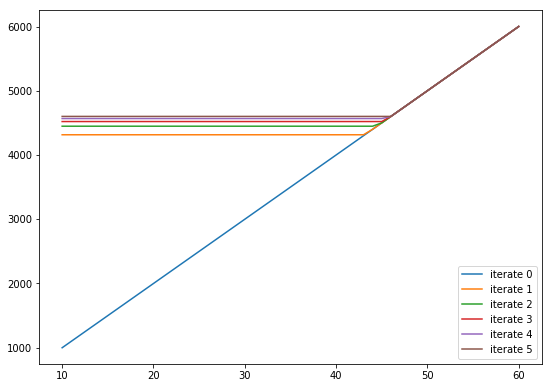

In [3]:
def plot_value_function_seq(ax,
                            c=25,
                            β=0.99,
                            w_vals=w_vals,
                            ϕ_vals=ϕ_vals,
                            num_plots=6):

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(w_vals, v, label=f"iterate {i}")
        # Update guess
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)
        v[:] = v_next

    ax.legend(loc='lower right')


fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

In [4]:
@jit(nopython=True)
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             ϕ_vals=ϕ_vals,
                             max_iter=500,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * ϕ_vals))

In [5]:
compute_reservation_wage()

47.316499710024964

In [6]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        R[i, j] = compute_reservation_wage(c=c, β=β)

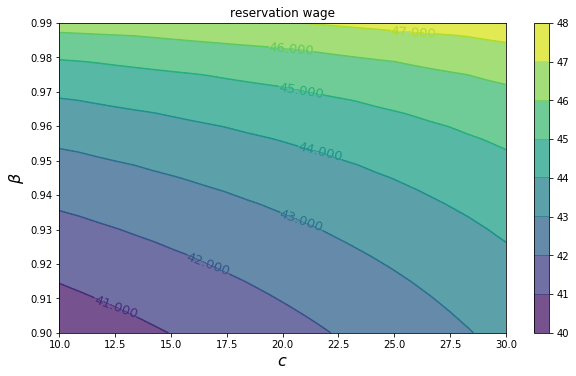

In [7]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

In [8]:
@jit(nopython=True)
def compute_reservation_wage_two(c=25,
                                 β=0.99,
                                 w_vals=w_vals,
                                 ϕ_vals=ϕ_vals,
                                 max_iter=500,
                                 tol=1e-5):

    # == First compute ϕ == #

    h = np.sum(w_vals * ϕ_vals) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w_vals / (1 - β), h)
        h_next = c + β * np.sum(s * ϕ_vals)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

Ecercise 1

![Ex1](img/mccall_1.png)

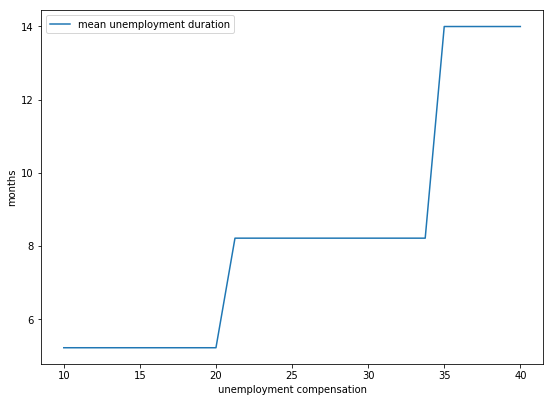

In [9]:
cdf = np.cumsum(ϕ_vals)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_vals[qe.random.draw(cdf)]
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 25)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    w_bar = compute_reservation_wage_two(c=c)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots(figsize=(9, 6.5))

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()



#### Lesson: Job Search II: Search and Separation¶

In [2]:
import numpy as np
from quantecon.distributions import BetaBinomial
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# A default utility function

@njit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6

class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                 α=0.2,        # Job separation rate
                 β=0.98,       # Discount factor
                 γ=0.7,        # Job offer rate
                 c=6.0,        # Unemployment compensation
                 σ=2.0,        # Utility parameter
                 w_vals=None,  # Possible wage values
                 ϕ_vals=None): # Probabilities over w_vals

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vals is None:
            n = 60  # number of possible outcomes for wage
            self.w_vals = np.linspace(10, 20, n)  # Wages between 10 and 20
            a, b = 600, 400  # shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.ϕ_vals = dist.pdf()
        else:
            self.w_vals = w_vals
            self.ϕ_vals = ϕ_vals

In [4]:
@njit
def Q(v, h, paras):
    """
    A jitted function to update the Bellman equations

    """

    α, β, γ, c, σ, w_vals, ϕ_vals = paras

    v_new = np.empty_like(v)

    for i in range(len(w_vals)):
        w = w_vals[i]
        v_new[i] = u(w, σ) + β * ((1 - α) * v[i] + α * h)

    h_new = u(c, σ) + β * (1 - γ) * h + \
                    β * γ * np.sum(np.maximum(h, v) * ϕ_vals)

    return v_new, h_new

In [5]:
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w_vals)   # Initial guess of v
    h = 1                          # Initial guess of h
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, h_new = Q(v, h, (mcm.α, mcm.β, mcm.γ, mcm.c, mcm.σ, \
                                mcm.w_vals, mcm.ϕ_vals)
                        )
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(h_new - h)
        error = max(error_1, error_2)
        v = v_new
        h = h_new
        i += 1

    return v, h

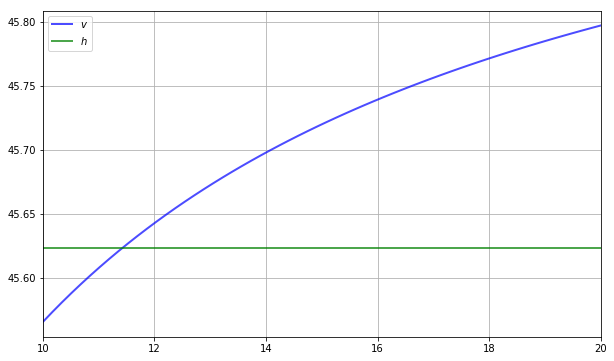

In [6]:
mcm = McCallModel()
v, h = solve_model(mcm)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mcm.w_vals, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax.plot(mcm.w_vals, [h] * len(mcm.w_vals),
        'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(mcm.w_vals), max(mcm.w_vals))
ax.legend()
ax.grid()

plt.show()

In [7]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) > h.

    If v(w) > h for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vals.

    If v(w) < h for all w, then w_bar is set to np.inf.
    """

    v, h = solve_model(mcm)
    w_idx = np.searchsorted(v - h, 0)

    if w_idx == len(v):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vals[w_idx]

    if not return_values:
        return w_bar
    else:
        return w_bar, v, h

Ecercise 1

![Ex1](img/js2_1.png)

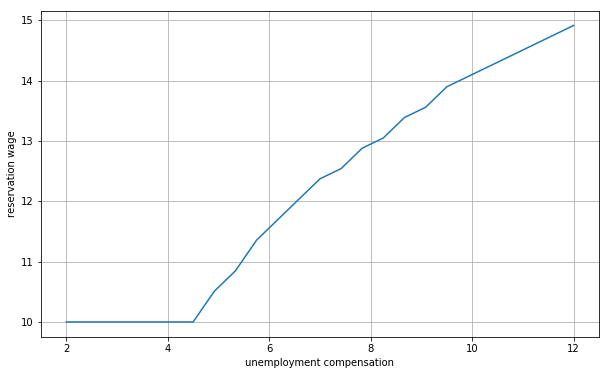

In [8]:
grid_size = 25
c_vals = np.linspace(2, 12, grid_size)  # Unemployment compensation
w_bar_vals = np.empty_like(c_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize=(10, 6))

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='unemployment compensation',
       ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.grid()

plt.show()

Ecercise 2

![Ex2](img/js2_2.png)

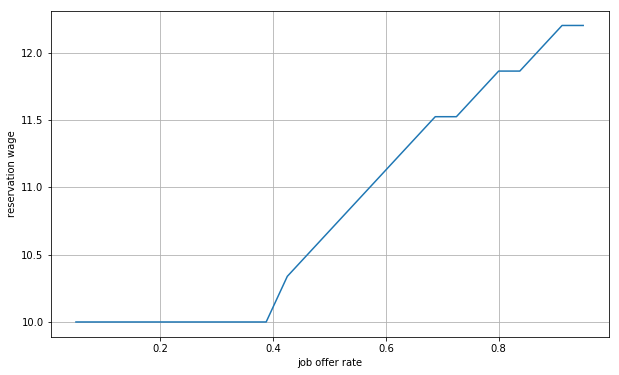

In [9]:
grid_size = 25
γ_vals = np.linspace(0.05, 0.95, grid_size)
w_bar_vals = np.empty_like(γ_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize=(10, 6))

for i, γ in enumerate(γ_vals):
    mcm.γ = γ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.plot(γ_vals, w_bar_vals, label=r'$\bar w$ as a function of $\gamma$')
ax.set(xlabel='job offer rate', ylabel='reservation wage')
ax.grid()

plt.show()

As seen from the graph, the increase in γ affects wage in a positive way.

That's because more jib offer rate results into better job search cobnitions.